In [9]:
import torch
import os
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
from softmax import SoftmaxModel
import collections
from scipy.ndimage import gaussian_filter, convolve
import time
from dataloaders import train_dataloader, test_dataloader
from torch import nn, optim
from scipy.ndimage import gaussian_filter, convolve
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import normalized_root_mse as nrmse
from skimage.metrics import structural_similarity as ssm
from utils import classes, c_to_i, get_orig, show_images

In [10]:
TRAIN_DIR = './data/processed/train/'
TEST_DIR = './data/processed/test/'

classes = os.listdir(TRAIN_DIR)
c_to_i = lambda x: classes.index(x)
i_to_c = lambda x: classes[x]

transformer = transforms.Compose([
    transforms.ToTensor(),
])

def show_img(im):
    plt.imshow(im.reshape(112, 92) / 2 + .5, cmap='gray')
    plt.show()
    
def one_hot(x):
    vec = [0] *len(classes)
    vec[x] = 1
    return vec
    
train =test= 0
train_x, train_y = ([0]) * 280, ([0]) * 280
test_x, test_y = ([0]) * 120, ([0]) * 120
asd = []

for c in os.listdir(TRAIN_DIR):
    for faces in os.listdir(TRAIN_DIR+c):
        img = np.array(Image.open(TRAIN_DIR+c+'/'+faces).convert('L'))
        train_x[train] = (img).flatten()
        train_y[train] = (c_to_i(c))
        train += 1

for c in os.listdir(TEST_DIR):
    for faces in os.listdir(TEST_DIR+c):
        img = np.array(Image.open(TEST_DIR+c+'/'+faces).convert('L'))
        test_x[test] = img.flatten()
        test_y[test] = (c_to_i(c))
        test += 1

train_x = np.stack([x.flatten() for x in train_x])
test_x = np.stack([x.flatten() for x in test_x])
test_y = np.array(test_y,  dtype=np.int64)
train_y = np.array(train_y, dtype=np.int64)

### Models

In [14]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.name = "MLP"
        self.linear1 = nn.Linear(10304, 3000)
        torch.manual_seed(666)
        torch.nn.init.ones_(self.linear1.weight)
        self.linear2 = nn.Linear(3000, 40)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.sigmoid(self.linear1(x))
        x = self.linear2(x)
        return x

In [15]:
def buildModel(model, lRate, plot=False, verbose=False):

    startTime = time.time()
    timeStr = time.strftime("%H:%M:%S", time.localtime(startTime))
    print("Starting at " + timeStr + " to build " + model.name + " model...")
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lRate)
    train_losses, validate_losses, accuracy_data = [], [], []
    valid_loss_min = np.Inf
    
    best_accuracy = 0
    iteration_count = 0
    total_iteration = 0
    
    # as in the paper, if there is no improvment after 100 iterations
    # stop training
    while iteration_count < 100:
        total_iteration += 1
        if (total_iteration%100==0): print("epoch: " + str(total_iteration))
        running_loss = 0
        for images, labels in train_dataloader:
            output = model(images)
            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        # epoch over
        iteration_count +=1
        
        validate_loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, labels in test_dataloader:
                samples = model(images)
                pred = samples.argmax(dim=1)
                accuracy = (pred == labels).sum().item() / len(labels)
                
            model.train()
            train_loss = running_loss / len(train_dataloader)
            train_losses.append(train_loss)
            accuracy_data.append(accuracy)
            
            
            if accuracy > best_accuracy:  # if we improve our accuracy, set the iteration count to 0
                if verbose:
                    print("Epoch: {}.. ".format(total_iteration))
                    print('Accuracy increased ({:.2f} --> {:.2f}). Saving model ...'.format(
                        best_accuracy, accuracy))
                torch.save(model.state_dict(), './models/'+model.name+"_model.pt")
                iteration_count = 0
                best_accuracy = accuracy  # update best accuracy

    endTime = time.time()
    dur = endTime - startTime
    timeStr = time.strftime("%H:%M:%S", time.localtime(endTime))
    print("Finished at " + timeStr + ", duration in sec: " + str(int(dur)))
    print("Total number of iterations ", total_iteration,", with accuracy of ", best_accuracy)
    return model

In [ ]:
softmax = buildModel(MLP(), 0.1, True, True)

Starting at 13:03:17 to build MLP model...
Epoch: 1.. 
Accuracy increased (0.00 --> 0.30). Saving model ...


### Reconstruction attack

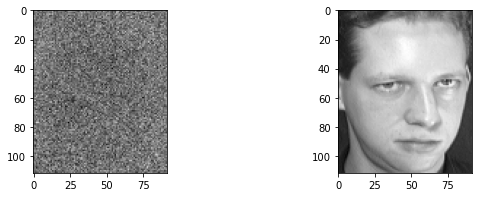

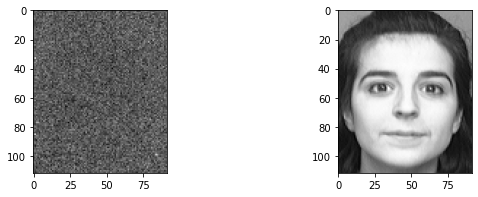

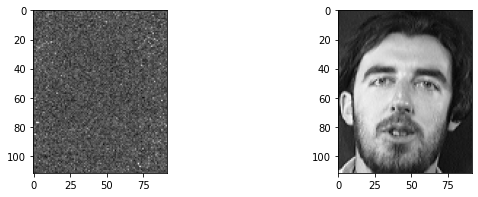

KeyboardInterrupt: 

In [60]:
from scipy.ndimage import gaussian_filter, convolve
pred = ''
def invert(model, img, lr, c, best_loss, best_x, i):
    img = torch.Tensor(img).view(1, -1)
    if not img.requires_grad:
        img.requires_grad = True
        
    optimizer.zero_grad()
    pred = model(img)
    loss = criterion(pred, torch.LongTensor([c]))
    loss.backward()    
    img = torch.clamp(img - lr * img.grad, 0, 255)

    if loss.detach().numpy() < best_loss and i > 10:
        best_loss = loss.detach().numpy()
        best_x = img.detach().numpy()

    filt = np.array([
        [0,-1,0],
        [-1,5,-1],
        [0,-1,0]
    ])
    np_a = np.array([np.clip(x + np.random.normal(2, 2),0,255) for x in img.detach().numpy()])
    # i = convolve(np_a.reshape(112, 92), filt)
    
    return best_loss, best_x, np_a.reshape(1, -1)
            
        
for c in classes:
    best_x,best_loss='',float('inf')
    img = np.zeros_like(train_x[0])
    for i in range(100):
        best_loss,best_x,img = invert(model, img, .01, c_to_i(c), best_loss, best_x, i)
    fig = plt.figure(figsize=(10, 3))
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(best_x.reshape(112, 92), cmap='gray')
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(test_x[c_to_i(c)*3].reshape(112, 92), cmap='gray')
    # plt.savefig(f'./data/results/class_{c}.png')
    plt.show()
    if (c=='s2'): break
    